# Quiz 2 : Summarization with Seq2Seq 

In [1]:
enter_name = "Minn Banya"
student_id = "st124145"

## Import library & Dataset (0 points)

In [2]:
# !pip install torch==2.1.1
# !pip install torchtext==0.16.1
# !pip install datasets
# !pip install spacy
# !python3 -m spacy download en_core_web_sm

In [3]:
from tqdm.auto import tqdm
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F
import random, math, time
from datasets import load_dataset
import pandas as pd
import numpy as np
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

C:\Users\minnb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [4]:
## Load CNN/DM dataset from huggingface
dataset = load_dataset('cnn_dailymail', '3.0.0')
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
## Load the train data and the validation data
train_data = dataset['train']
valid_data = dataset['validation']

In [6]:
columns = list(train_data.features.keys())
columns.pop()
columns

['article', 'highlights']

In [7]:
#checking
train_data[0]['article'], train_data[0]['highlights']

('LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details 

## Preprocessing (2 points)
- Convert the dataset into pandas DataFrame with proper column names
    - The training dataset is too big use only 1000 sample maximum
    - The validation dataset is too big use only 200 sample maximum
- lowercase everything
- remove unnecessary words that would not make sense
- remove linebreaks and backslashes 


In [8]:
###Convert the dataset into pandas DataFrame with proper column names
df_train =  [[i['article'], i['highlights']] for i in train_data]
df_valid = [[i['article'], i['highlights']] for i in valid_data]
train_df = pd.DataFrame(df_train, columns = columns)
valid_df = pd.DataFrame(df_valid, columns = columns)

In [9]:
### The training dataset is too big use only 1000 sample maximum
### The validation dataset is too big use only 200 sample maximum
#code here
train_df = train_df[:1000]
valid_df = valid_df[:200]
train_df.shape, valid_df.shape

((1000, 2), (200, 2))

In [10]:
# Applying Lower Case to the text
#code here
#hint : using apply
#traing dataset
train_df['article']  =  train_df['article'].apply(str.lower)
train_df['highlights'] =  train_df['highlights'].apply(str.lower)
#validation dataset
valid_df['article']  =  valid_df['article'].apply(str.lower)
valid_df['highlights'] =  valid_df['highlights'].apply(str.lower)

In [11]:
###Removing unnesscary words 
###Using Regex
def data_cleaning(data):
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|-", "", data)
    fin = " ".join(regex_s.split())
    return fin

asd = "(cnn) has do the right thang? \n he has -- a new show "
data_cleaning(asd)

'has do the right thang? he has a new show'

In [12]:
#code here
#using above function to apply removing unnesscary words
#hint : using apply
train_df['article']  = train_df['article'].apply(data_cleaning)
train_df['highlights'] =  train_df['highlights'].apply(data_cleaning)
valid_df['article']  =  valid_df['article'].apply(data_cleaning)
valid_df['highlights'] = valid_df['highlights'].apply(data_cleaning)

In [13]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [14]:
def yield_tokens(data):
    #complete this code
    for datasample in data:
        yield tokenizer(datasample)

In [15]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [16]:
from torchtext.vocab import build_vocab_from_iterator
#code here
#assuming 'article' column has all the words in 'highlights'
vocab_transform = build_vocab_from_iterator(yield_tokens(train_df['article']),   
                                                    specials=special_symbols,
                                                    special_first=True)

In [17]:
vocab_transform.set_default_index(UNK_IDX)

In [18]:
len(vocab_transform)

30624

In [19]:
#testing
mapping = vocab_transform.get_itos()
mapping[200]

'around'

## Data Loader (1 point)

###  FastText Embedding

In [20]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [21]:
#code here
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab_transform.get_itos()).to(device)

In [22]:
fast_embedding.shape 

torch.Size([30624, 300])

In [63]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE = 10

def sequencetial_transforms(*transforms):
    #code here
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids):
    #code here
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

text_transform = {}
text_transform = sequencetial_transforms(tokenizer,
                                           vocab_transform,
                                            tensor_transform)
def collate_batch(batch): 
    #code here
    src_batch,src_length, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform(src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform(trg_sample.rstrip("\n")))
        src_length.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_length, dtype=torch.int64), trg_batch

In [64]:
class DataWrap(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [65]:
train_df.iloc[0]

article       london, england harry potter star daniel radcl...
highlights    harry potter star daniel radcliffe gets £20m f...
Name: 0, dtype: object

In [66]:
train = DataWrap(train_df)
valid = DataWrap(valid_df)

In [67]:
batch_size = 10
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [68]:
for src,_, tgt in train_loader:
    break

In [69]:
src.shape, tgt.shape

(torch.Size([1008, 10]), torch.Size([62, 10]))

## Create a model  (2 points)
- Create a Seq2Seq attention model  
- The Attention shoud be Multiplicative Attention  not Additive Attention
- The main model must take "target" as optional. So that we dont have to pass target in inference.
Also include max summary length, teacher forcing etc. 


### Encoder

In [70]:
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #embedding
        embedded = self.dropout(self.embedding(src))
        #packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        #rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        #unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #-1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        #outputs: [src len, batch_size, hid dim * 2]
        #hidden:  [batch_size, hid_dim]
        
        return outputs, hidden

### Decoder

In [71]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]

        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
        #concatenate (embed, weighted encoder_outputs)
        #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
        #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

The Attention shoud be Multiplicative Attention not Additive Attention

Multiplicative Attention : 

$e_i = s^T W h_i \in \mathbb{R} ; \textbf{W} \in \mathbb{R}^{d_2 × d_1}$


In [72]:
#Multiplicative Attention
class MultiplicativeAttention(nn.Module):
    #code here
    def __init__(self, hid_dim):
        super().__init__()
        
        self.W = nn.Linear(hid_dim * 2, hid_dim)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]  #this is from the decoder....so no n_layers
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        hidden = hidden.unsqueeze(2)
        mul = self.W(encoder_outputs).unsqueeze(3)
        # print(hidden.shape, mul.shape)
        energy = torch.matmul(hidden, mul)
        #energy = [batch size, src len, hid dim]
        # print(energy.shape)
        attention = energy.squeeze(2)
        attention = attention.squeeze(2)
        #attention= [batch size, src len]
        # print(attention.shape, mask.shape)
        attention = attention.masked_fill(mask, -1e10)
        return F.softmax(attention, dim=1)

The main model must take "target" as optional. So that we dont have to pass target in inference. Also include max summary length, teacher forcing etc. 

In [119]:
import random
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
    
    def forward(self, src, src_len, teacher_forcing_ratio=0.5, max_length = 10, trg=None):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size     = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        if trg is not None:
          trg_len        = trg.shape[0]
        else:
           trg_len = 1
        sum_len        = max_length 
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device) #code here 
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device) #code here

        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len) 
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        if trg is not None:
          input_ = trg[0, :]
        else:
          input_ = torch.tensor(SOS_IDX)
            
        mask = self.create_mask(src)
        for t in range(1, sum_len):
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]

            # print(outputs.shape, output.shape)
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            if trg is not None: 
              input_ = trg[t] if teacher_force else top1
            else:
              input_ = top1 #code here

        return outputs, attentions

In [120]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)       

### Quick Note: Apply the fasttext embedding to the model

In [121]:
input_dim = len(vocab_transform)
output_dim = len(vocab_transform)
emb_dim =  300 #code here
hid_dim =  512 #code here
dropout = 0.5
SRC_PAD_IDX = PAD_IDX

attn = MultiplicativeAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

#Applying FastText embedding to the Encoder and the Decoder
#code here
enc.embedding.weight.data = fast_embedding
dec.embedding.weight.data = fast_embedding

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(30624, 300)
    (rnn): GRU(300, 300, bidirectional=True)
    (fc): Linear(in_features=600, out_features=300, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiplicativeAttention(
      (W): Linear(in_features=600, out_features=300, bias=True)
    )
    (embedding): Embedding(30624, 300)
    (rnn): GRU(900, 300)
    (fc): Linear(in_features=1200, out_features=30624, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [122]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

9187200
270000
270000
   900
   900
270000
270000
   900
   900
180000
   300
180000
   300
9187200
810000
270000
   900
   900
36748800
 30624
______
57679824


In [123]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

## Train & Ploting (2 points)

In [124]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    #code here
    model.train()
    epoch_loss = 0
    
    for src,src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg = trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        # print(output.shape, trg.shape)
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        # print(output.shape, trg.shape)
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [125]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    #code here
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
            
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg = trg, teacher_forcing_ratio = 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
    
        
    return epoch_loss / loader_length

In [126]:
train_loader_length = len(list(iter(train_loader))) 
valid_loader_length = len(list(iter(valid_loader))) 
train_loader_length, valid_loader_length

(100, 20)

In [127]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [128]:
#code here
best_valid_loss = float('inf')
num_epochs = 1
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, valid_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 32s
	Train Loss: nan | Train PPL:     nan
	 Val. Loss: nan |  Val. PPL:     nan


### Plot the losses

Text(0, 0.5, 'loss')

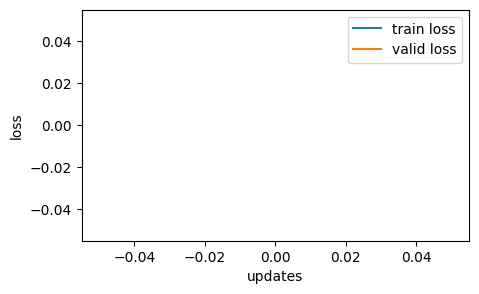

In [129]:
#code here
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## Finally we can summarize (1 points)
- Summarize the given sample (The max length of summary should be 20 tokens)

In [130]:
###Summarize the given sample
max_len = 20
sample = """Mrs Kopta, who has dementia, has been living in a nursing home after she was taken in as a person in need seven years after she disappeared. 
It's a relief she hasn't been murdered. Her husband Bob Kopta said he had been married to Mrs Kopta for 20 years before she went missing. 
He said: It's a relief knowing that she's not laying in a ditch somewhere, or murdered somewhere. 
The 86-year-old added that his family suspected she may be in Puerto Rico but she was declared dead around 25 years ago. 
The retired electrician also said he had consulted with a psychic about her whereabouts. 
Mrs Kopta has two sisters - a twin, who died six years ago, and a younger sister who was relieved to learn she's still alive, Mr Kopta added. 
He said he has experienced a range of emotions over the years but is content knowing his wife is alive and being cared for. 
After 30 years, you try to forget about it. Now I can forget about it. 
We know what happened, and she is taken care of now, he said."""

In [131]:
#lower case
#clean text as well
processed_sample = data_cleaning(sample.lower())
input = text_transform(processed_sample).reshape(-1,1)

In [132]:
input.size(0)

213

In [134]:
#code here
model.eval()
input = input.to(device)
output, attention = model(input,input.size(0))
output = output.squeeze(1)
output = output[1:]
output_max = output.argmax(1)
mapping = vocab_transform.get_itos()
for token in output_max:
    print(mapping[token.item()])

AttributeError: 'int' object has no attribute 'to'

## Conclusion (2 points)
- How did the model perform?
- Does using the FastText Embedding improve the performance?
- What do you suggest we can do to increase the performance in text summarization?

The model performed quite bad due to limited resource and training.
FastText embedding improve the performance signitficantly
We can increase training size, epoch and learning rate decrease.